# Functions of differential operators - 1D

In this notebook we will learn how to

* compute functions (including exponential) of differential operators (`diffopexp`),
* work with symbols in 1D (`fouriersymbol`, `fourierproduct`, `fourierfn`).

[Back to tensorgrid quick introduction](00_quick_introduction.ipynb). 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import time

import numpy as np

import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex

import torch
from torch import exp, sin, cos, abs, real, imag, pi, max, diag, float32, eye, kron
from torch.linalg import norm, matrix_exp

error = lambda u, uref : max(abs(u.flatten()-uref.flatten()))

c:\ProgramData\Anaconda3\envs\torchcomplex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creating and applying a 1D symbol

Since the Fourier  differentiation matrix is diagonalized by the Fourier transform,

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} $$

it follows that

$$ \left(\mathbf{D}_k\right)^n = \mathcal{F}^{-1} \texttt{diag}((s_k)^n) \mathcal{F} $$

For any analytic function $g$, by Taylor expansion it follows that

$$ g(c \mathbf{D}_k) = \mathcal{F}^{-1} \texttt{diag}(g(c s_k)) \mathcal{F} $$

for any $c \in \mathbb{C}$, and it's action on a vector $u$ is computed in $\mathcal{O}(n \log n)$ operations as 

$$ g(c \mathbf{D}_k) u= \mathcal{F}^{-1} \texttt{diag}(g(c s_k)) \mathcal{F} u = \texttt{ifft}\left( g(c s_k) \texttt{fft}(u) \right) .$$

Since $g$ only acts on $c s_k$ which involved $\mathcal{O}(n)$ operations, the computation of $g(c \mathbf{D}_k) u$ is almost as expensive as a single computation of $\mathbf{D}_k$ using FFT: i.e. $\mathcal{O}(n \log n)$.

#### $\star$ `fouriersymbol` and `fourierproduct`



The first component that we need for computing arbitrary functions of differential operators is the symbol $s_k$. The 1D symbol of the first differential operator (i.e. $\mathbf{D}_1$) can be created in `tensorgrid` using

```Python
    sk = ex.fouriersymbol(n, xrange)
```

where `n` is the number of grid points and `xrange` is the spatial domain. We can then compute the first derivative as

```Python
    dfs = ex.fourierproduct(sk, f, 0)
```

the third derivative as

```Python
    d3fs = ex.fourierproduct(sk**3, f, 0)
```

Here the third parameter is the dimension in which the fourier symbol needs to be applied. In 1D case this is always 0.

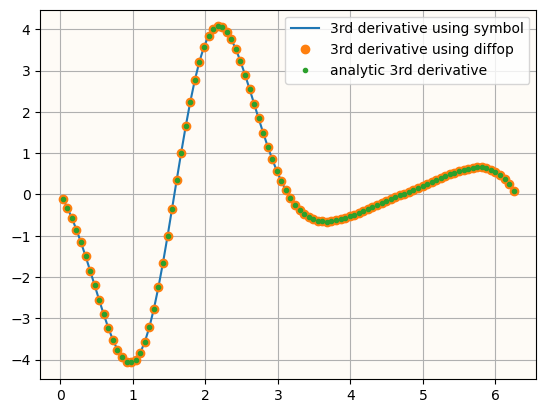

In [2]:
xrange = [0, 2*pi]
n = 100
x = ex.grid1d(n, xrange)

f = exp(sin(x))

df_true = cos(x)*exp(sin(x))
df = ex.diffop(0, 1, f, xrange)

d3f_true = -cos(x)*exp(sin(x)) + -sin(x)*cos(x)*exp(sin(x)) + (cos(x)**3)*exp(sin(x)) -2.*sin(x)*cos(x)*exp(sin(x)) 
d3f = ex.diffop(0, 3, f, xrange)

sk = ex.fouriersymbol(n, xrange)

dfs = real(ex.fourierproduct(sk, f, 0))
d3fs = real(ex.fourierproduct(sk**3, f, 0))

fig, ax = plt.subplots()
ex.plot(ax, x, d3fs)
ex.plot(ax, x, d3f, marker='o',linestyle=' ')
ex.plot(ax, x, d3f_true, marker='.',linestyle=' ')
plt.legend(['3rd derivative using symbol', '3rd derivative using diffop', 'analytic 3rd derivative'])
plt.show()

Note that this implements the functionality already available in `diffop`. However, `diffop` also takes care of managing real and complex-valued inputs appropriately. Here we have had to explicitly take the real component of the `fourierproduct` output.

The relevance of the symbol way of doing things is that we can now compute arbitary functions of differential operators, e.g. we can compute $g(c\mathbf{D}_1) f$ as 
```Python
    dgfs = ex.fourierproduct(g(c * sk), f, 0)
```
where the last parameter is the dimension along which the fourier symbol needs to act. We demonstrate this with $g(s)=$

$$\quad \exp(s^2),  \quad \exp(s), \quad \sin(s^2), \quad \text{and} \quad \exp(i s^2 + 5 s), $$

which effectively compute the actions of 

$$ e^{\partial_x^2}, \quad e^{\partial_x}, \quad \sin\left(\partial_x^2\right), \quad \text{and} \quad e^{i \partial^2_x + 5 \partial_x}, $$

respectively.

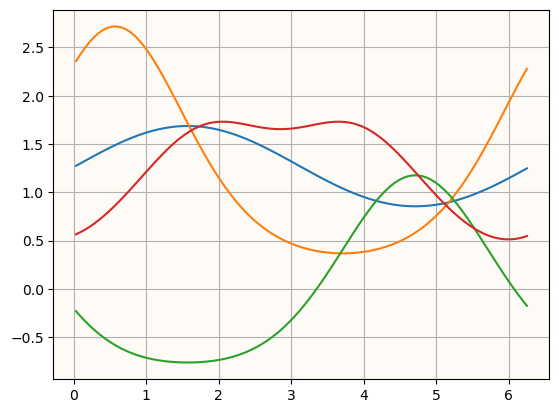

In [3]:
glist = [lambda s: exp(s**2), lambda s: exp(s), lambda s: sin(s**2), lambda s: exp(1j*s**2 + 5.*s)]

dgfs = [ex.fourierproduct(g(sk), f, d=0) for g in glist]

dgfs[0] = real(dgfs[0])
dgfs[1] = real(dgfs[1])
dgfs[2] = real(dgfs[2])

fig, ax = plt.subplots()
for dg in dgfs:
    ex.plot(ax, x, real(dg))   # showing only the real part of dgfs[3]
plt.show()

With the exception of the last operator, which results in complex-valued function, all other functions should be real-valued, so we extract the real component after computing the `fourierproduct`.





#### $\star$ `fourierfn`


The function `fourierfn` provides the same functionality as the combination of `fouriersymbol` and `fourierproduct`, and can be used for more compact code. We can simply call it as

```Python
    dgf = ex.fourierfn(g, f, 0, xrange)
```

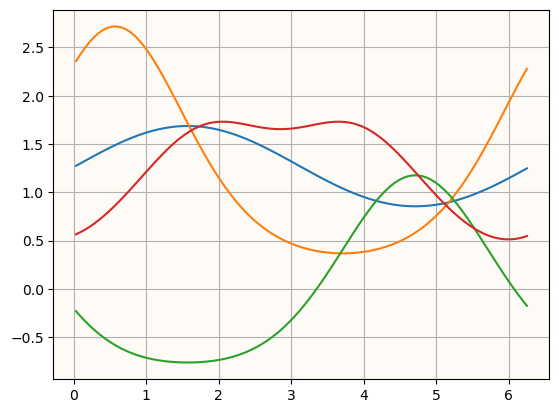

In [4]:
glist = [lambda s: exp(s**2), lambda s: exp(s), lambda s: sin(s**2), lambda s: exp(1j*s**2 + 5.*s)]

dgf = [ex.fourierfn(g, f, 0, xrange) for g in glist]

dgf[0] = real(dgf[0])
dgf[1] = real(dgf[1])
dgf[2] = real(dgf[2])

fig, ax = plt.subplots()
for dg in dgf:
    ex.plot(ax, x, real(dg))   # showing only the real part of dgf[3]
plt.show()

Internally, `fourierfn` creates a symbol $s_k$ for every application. So although it is more compact, the combination of `fouriersymbol` with `fourierproduct` is more efficient in general applications.

#### $\star$ `diffopexp`

A very commonly used function in the solution of differential equations is the exponential of a differential operator. This functionality is implemented in the function `diffopexp`, whose syntax is:


```Python
    eDkf = ex.diffopexp(0, k, c, f, xrange) 
```
which computes $\exp(c \partial^k_x) f$, where `f` is the dicretized function. The first component is always $0$ in 1D, indicating differentiation with respect to `x`.

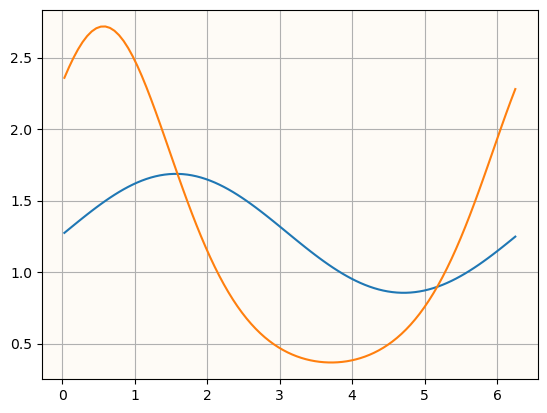

In [5]:
eD2f = ex.diffopexp(0, 2, 1., f, xrange) 
eD1f = ex.diffopexp(0, 1, 1., f, xrange) 

fig, ax = plt.subplots()

ex.plot(ax, x, eD2f)
ex.plot(ax, x, eD1f)
plt.show()

We have already computed these using `fourierfn` (as well as `fouriersymbol` and `fourierproduct` approach). We can check that these approaches lead to the same solution.

In [30]:
print(error(eD2f, dgf[0]))
print(error(eD1f, dgf[1]))

tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)


* `diffopexp` takes care of real and complex-valued inputs appropriately (unlike `fourierfn` and `fourierproduct` etc), and we didn't have to typecast to `real`.
* `diffopexp` is as efficient as `fourierfn` (and utilizes this internally), and is therefore less efficient than the combination of `fouriersymbol` and `fourierproduct` for multiple runs.